# 第3週：傲慢與偏見情緒分析
**Author:** 黃天原<br>
**Date created:** 2021/09/30<br>
**Last modified:** 2021/09/30<br>
本週課程為「情緒分析1」，目的為了解lexicon-base 情緒分析。情緒分析步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「英文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中，我們將會介紹所使用到的套件、資料前處理、lexicon-base 情緒分析

## 大綱
+ 1. 套件說明
+ 2. 資料前處理
+ 3. lexicon-base 情緒分析
    + 3.1 準備LIWC情緒字典
    + 3.2 情緒字典與斷詞結果進行合併
    + 3.3 正負向情緒分數聲量長條圖
    + 3.4 正負向情緒分數比例折線圖
    + 3.5 文字雲
      + 第18章文字雲
    + 3.6 情緒代表字
      + ch.18 正負相情緒代表字
    + 3.7 各章情緒分數

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- re: 正規表達式套件。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。

In [65]:
# 安裝會使用到的套件
# %pip install wordcloud

In [66]:
# 確認當前工作目錄
%pwd

'/Users/evan19983314/course/SMA/SMA_2023S/week4_sentiment_analysis'

In [67]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
nltk.download("punkt") # 下載需要用到的語料庫
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 150

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/evan19983314/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2. 資料前處理
基本上在前一次上課的內容已經提過，本節課直接沿用前一次課程清理完成的文集結果。

## 3. lexicon-base 情緒分析
進行基於情緒字典的情緒分析，首先需要準備情緒字典後再將字典與斷詞後的文章進行合併

### 3.1 準備LIWC情緒字典與清理完成的傲慢與偏見
- 全名Linguistic Inquiry and Word Counts，由心理學家Pennebaker於2001出版  
- 分為正向情緒與負向情緒

In [68]:
# 讀取情緒字典
en_dict_path = "./dict/liwc/LIWC_EN.csv"
liwc_dict = pd.read_csv(en_dict_path)
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict

,word,sentiments
0,(:,affect
1,):,affect
2,:(,affect
3,:),affect
4,abandon,affect
...,...,...
3280,whine,sad
3281,whining,sad
3282,woe,sad
3283,worthless,sad


In [69]:
liwc_dict['sentiments'].value_counts()

affect      1416
negative     745
positive     642
anger        230
sad          136
anx          116
Name: sentiments, dtype: int64

>  就英文版的LIWC2007來說，目前包含了64個定義類別。這些類別包括基本的語文向度類別，例如： 22個語文特性類別（如，代名詞、冠詞等百分比）、3個副語言學（paralinguistic）類別（如應和詞、停頓詞等）。除了已經有具有明確定義的語文類別之外，LIWC也另外包含了32個心理特性類別（如，情感詞、認知詞等）、7個個人化類別（如工作、休閒活動等）。再加上程式自動計算出的6個一般描述性類別（總詞數、每句詞數等）以及12個標點符號類別（如句點、逗點等），總計可輸出80個字詞類別。
- https://cliwc.weebly.com/liwc20073542220856.html 
- https://cliwc.weebly.com/35422208563900621029200131228933521259913549826126.html

在前一次上課的文字處理，會把傲慢與偏見的英文處理好，因此請讀入前次的 `csv` 檔案

In [70]:
path = "../week3_nlp/raw_data/clean_en_data.csv" # 你可以換成自己的傲慢與偏見位置，理論上是這個
book_df = pd.read_csv(path, index_col=False)
book_df

,sentence,chapter,token,word,lemma_token
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudice
2,It is a truth universally acknowledged that a ...,1,truth,truth,truth
3,It is a truth universally acknowledged that a ...,1,universally,universally,universally
4,It is a truth universally acknowledged that a ...,1,acknowledged,acknowledged,acknowledged
...,...,...,...,...,...
52253,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person
52254,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bringing
52255,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshire
52256,Darcy as well as Elizabeth really loved them a...,61,means,means,mean


### 3.2 情緒字典與斷詞結果進行合併
將情緒字典與斷詞結果進行合併。

In [71]:
book_liwc_df = pd.merge(book_df, liwc_dict, how = 'left')
book_liwc_df

,sentence,chapter,token,word,lemma_token,sentiments
0,TPRIDE PREJUDICE,0,TPRIDE,tpride,tpride,NaN
1,TPRIDE PREJUDICE,0,PREJUDICE,prejudice,prejudice,NaN
2,It is a truth universally acknowledged that a ...,1,truth,truth,truth,affect
3,It is a truth universally acknowledged that a ...,1,truth,truth,truth,positive
4,It is a truth universally acknowledged that a ...,1,universally,universally,universally,NaN
...,...,...,...,...,...,...
58812,Darcy as well as Elizabeth really loved them a...,61,persons,persons,person,NaN
58813,Darcy as well as Elizabeth really loved them a...,61,bringing,bringing,bringing,NaN
58814,Darcy as well as Elizabeth really loved them a...,61,Derbyshire,derbyshire,derbyshire,NaN
58815,Darcy as well as Elizabeth really loved them a...,61,means,means,mean,NaN


In [72]:
# 算出每章情緒總和(sentiment_count)

sentiment_count = pd.DataFrame(book_liwc_df.groupby(['chapter', 'sentiments'], dropna=False).size()).reset_index()
print(sentiment_count)

sentiment_count = sentiment_count.rename(columns={0: 'size'})
sentiment_count

     chapter sentiments    0
0          0        NaN    2
1          1     affect   47
2          1      anger    2
3          1        anx    2
4          1   negative    9
..       ...        ...  ...
416       61        anx    2
417       61   negative   14
418       61   positive   44
419       61        sad    4
420       61        NaN  500

[421 rows x 3 columns]


,chapter,sentiments,size
0,0,NaN,2
1,1,affect,47
2,1,anger,2
3,1,anx,2
4,1,negative,9
...,...,...,...
416,61,anx,2
417,61,negative,14
418,61,positive,44
419,61,sad,4


### 3.3 正負向情緒分數聲量長條
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [73]:
pos = sentiment_count[sentiment_count['sentiments']=='positive']
neg = sentiment_count[sentiment_count['sentiments']=='negative']

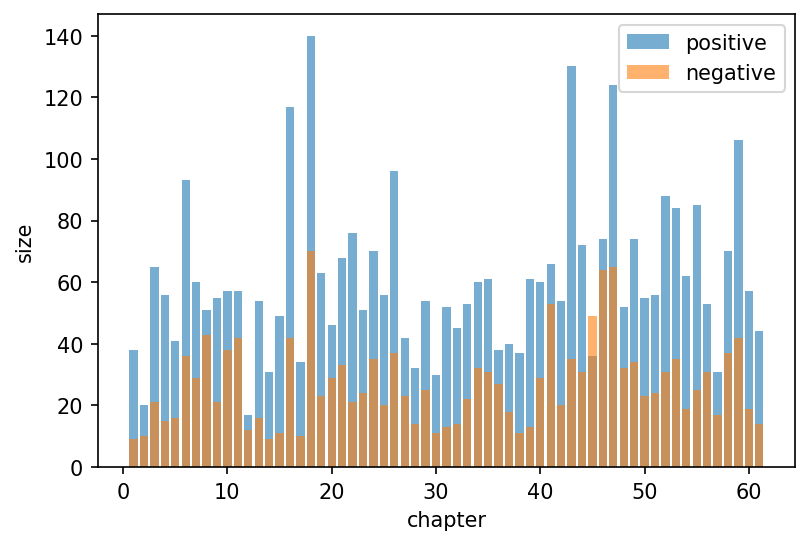

In [74]:
# you can find other color pattern here: https://matplotlib.org/stable/gallery/color/named_colors.html
colors = ["tab:blue",  "tab:orange"]
fig, ax = plt.subplots()

ax.bar(pos['chapter'],
       pos['size'],
       color = colors[0],
       alpha = 0.6,
       align='center')
ax.bar(neg['chapter'],
       neg['size'], 
       color = colors[1],
       alpha = 0.6,
       align='center')
plt.xlabel('chapter')
plt.ylabel('size')

ax.legend(['positive','negative'], loc ='upper right') 
plt.show()

In [75]:
pos.loc[pos['chapter'].isin(range(15,25))]

,chapter,sentiments,size
101,15,positive,49
108,16,positive,117
113,17,positive,34
120,18,positive,140
127,19,positive,63
134,20,positive,46
141,21,positive,68
148,22,positive,76
155,23,positive,51
162,24,positive,70


In [76]:
pos.loc[pos['chapter'].isin(range(40,45))]

,chapter,sentiments,size
271,40,positive,60
278,41,positive,66
285,42,positive,54
292,43,positive,130
299,44,positive,72


畫出每章的情緒總分數，可以看到正向情緒在 18 與 43 章較高

### 3.4 正負向情緒分數比例折線圖圖

In [77]:
sentiment_count

,chapter,sentiments,size
0,0,NaN,2
1,1,affect,47
2,1,anger,2
3,1,anx,2
4,1,negative,9
...,...,...,...
416,61,anx,2
417,61,negative,14
418,61,positive,44
419,61,sad,4


In [78]:
sentiment_count.groupby('chapter')['size'].transform(lambda n : n/n.sum())

0      1.000000
1      0.118687
2      0.005051
3      0.005051
4      0.022727
         ...   
416    0.003185
417    0.022293
418    0.070064
419    0.006369
420    0.796178
Name: size, Length: 421, dtype: float64

In [79]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("chapter")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,chapter,sentiments,size,ratio
0,0,NaN,2,1.000000
1,1,affect,47,0.118687
2,1,anger,2,0.005051
3,1,anx,2,0.005051
4,1,negative,9,0.022727
...,...,...,...,...
416,61,anx,2,0.003185
417,61,negative,14,0.022293
418,61,positive,44,0.070064
419,61,sad,4,0.006369


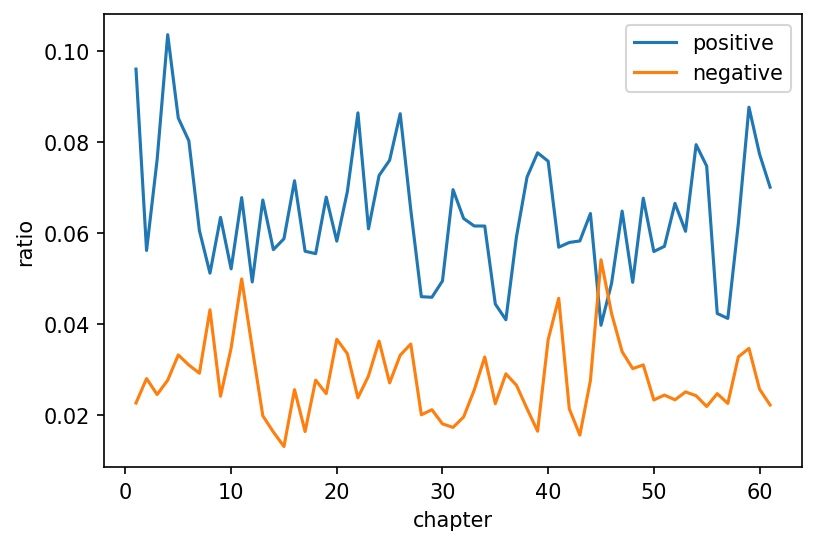

In [80]:
pos = sentiment_count[sentiment_count['sentiments']=='positive']
neg = sentiment_count[sentiment_count['sentiments']=='negative']
fig, ax = plt.subplots()

ax.plot(pos['chapter'],
       pos['ratio'],
       color = colors[0])
ax.plot(neg['chapter'],
       neg['ratio'], 
       color = colors[1])
plt.xlabel('chapter')
plt.ylabel('ratio')

ax.legend(['positive','negative'], loc ='upper right') 

### 3.5 文字雲
針對不同章節畫出該章的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [81]:
# 先看看正面詞出現最多的章節
sentiment_count.loc[sentiment_count['sentiments'] == 'positive'].sort_values("size", ascending=False)

,chapter,sentiments,size,ratio
120,18,positive,140,0.055489
292,43,positive,130,0.058270
320,47,positive,124,0.064820
108,16,positive,117,0.071472
404,59,positive,106,0.087603
...,...,...,...,...
390,57,positive,31,0.041278
94,14,positive,31,0.056364
204,30,positive,30,0.049505
11,2,positive,20,0.056180


#### 第 18 章


In [83]:
## 篩選出 18 章且正向情緒的詞彙
mask = (book_liwc_df['chapter']==18) & (book_liwc_df['sentiments']=='positive')
book_tf_by_ch_df = book_liwc_df.loc[mask]
book_tf_by_ch_df

,sentence,chapter,token,word,lemma_token,sentiments
13383,She had dressed with more than usual care and ...,18,care,care,care,positive
13392,She had dressed with more than usual care and ...,18,trusting,trusting,trusting,positive
13418,But in an instant arose the dreadful suspicion...,18,eagerly,eagerly,eagerly,positive
13441,But in an instant arose the dreadful suspicion...,18,certain,certain,certain,positive
13445,This part of his intelligence though unheard b...,18,intelligence,intelligence,intelligence,positive
...,...,...,...,...,...,...
15785,When at length they arose to take leave Mrs_Be...,18,hope,hope,hope,positive
15796,When at length they arose to take leave Mrs_Be...,18,happy,happy,happy,positive
15826,Mrs_Bennet was perfectly satisfied and quitted...,18,perfectly,perfectly,perfectly,positive
15863,Elizabeth was the least dear to her of all her...,18,dear,dear,dear,positive


In [84]:
wc_18 = book_tf_by_ch_df.groupby(['word']).size().to_dict()
Counter(wc_18).most_common(20)

[('well', 8),
 ('happy', 6),
 ('perfectly', 6),
 ('certain', 5),
 ('hope', 5),
 ('sure', 5),
 ('dear', 4),
 ('good', 4),
 ('agreeable', 3),
 ('care', 3),
 ('compliment', 3),
 ('determined', 3),
 ('great', 3),
 ('kind', 3),
 ('party', 3),
 ('success', 3),
 ('superior', 3),
 ('agreement', 2),
 ('comfort', 2),
 ('confidence', 2)]

In [85]:
len(wc_18)

76

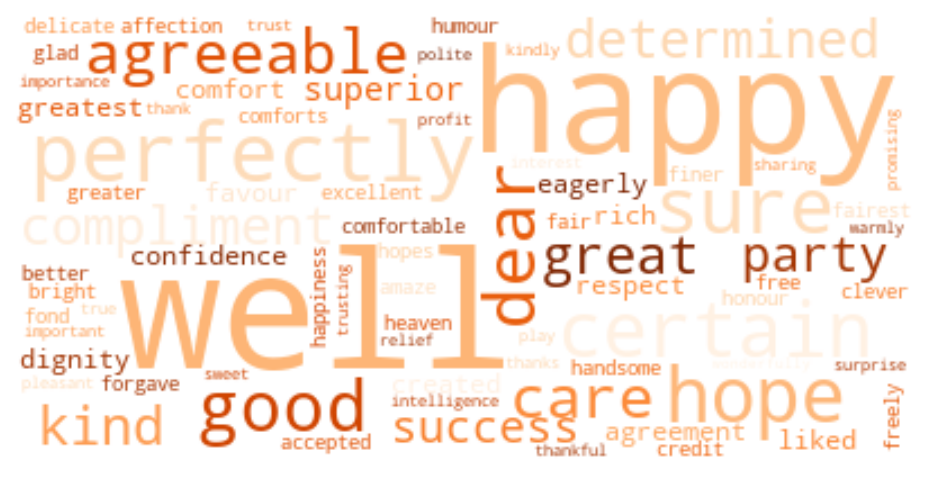

In [86]:
## wordcloud 的 input 是一個 dict, key是 word, value 是次數
# wc_18['assure']
cloud = WordCloud(max_words=200, background_color="white", colormap="Oranges")
cloud.generate_from_frequencies(wc_18)
# 繪圖
# plt.figure(figsize=(10,5), dpi=300)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### 3.6 情緒代表字
從整個文集中計算出正負向情緒字的出現詞頻，並找出情緒的代表字

In [87]:
word_count = book_liwc_df.groupby(['word', 'sentiments']).size().reset_index()
word_count.columns = ['word', 'sentiments','size']
word_count.sort_values("size", ascending=False)

,word,sentiments,size
638,miss,negative,281
637,miss,affect,281
639,miss,sad,281
1112,well,positive,211
1111,well,affect,211
...,...,...,...
557,kill,anger,1
912,splendor,positive,1
911,splendor,affect,1
558,kill,negative,1


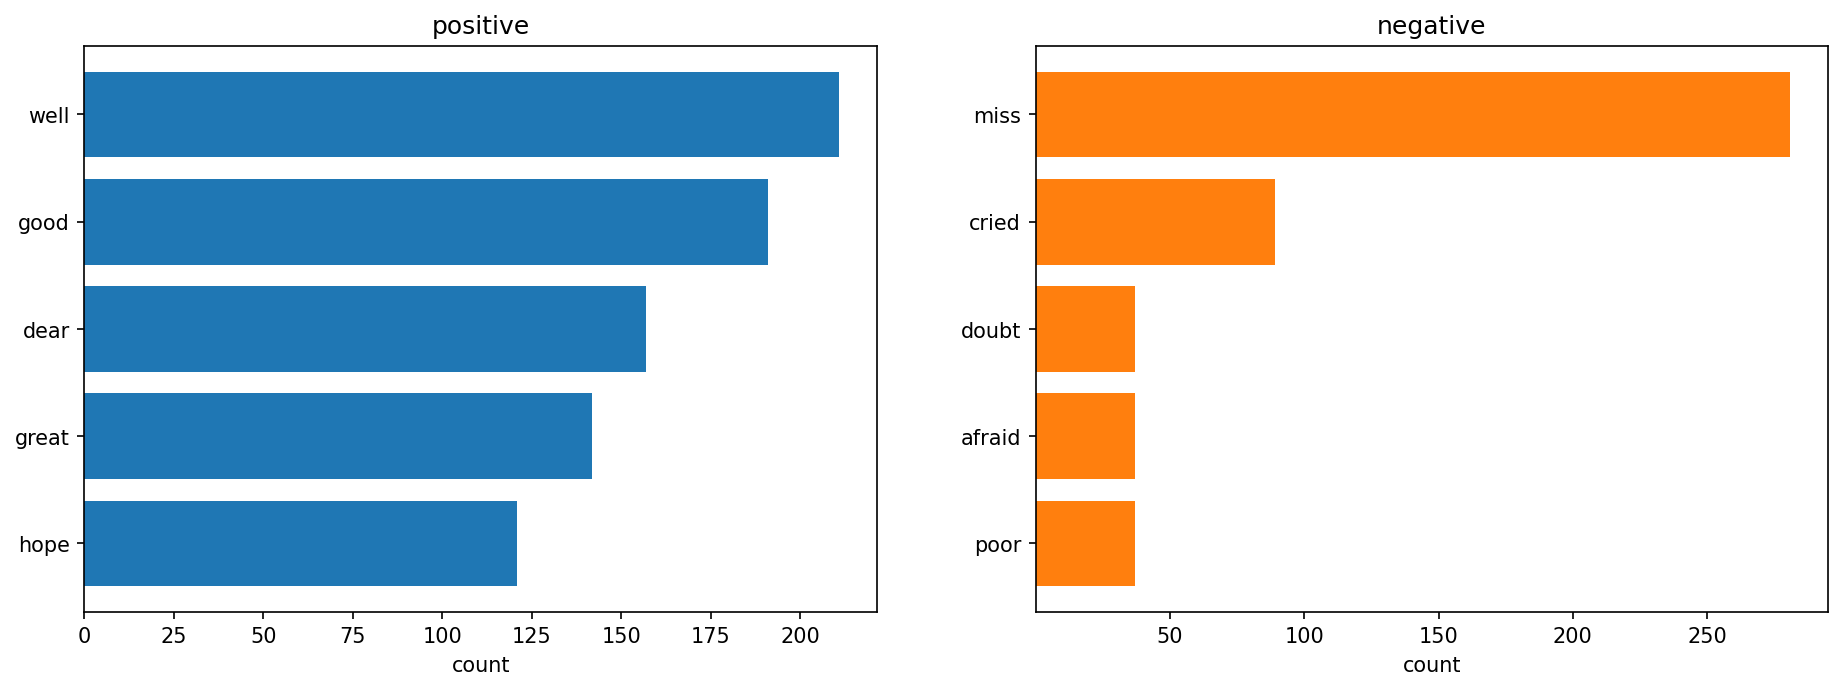

In [88]:
pos = word_count[word_count['sentiments']=='positive'].sort_values(['size'],ascending=True)
pos = pos[-5:]
neg = word_count[word_count['sentiments']=='negative'].sort_values(['size'],ascending=True)
neg = neg[-5:]
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].barh(pos['word'],
           pos['size'],
           color = colors[0])
ax[0].set_xlabel('count')
ax[0].set_title("positive")

ax[1].xaxis.set_ticks([25,50,75,100,125,150,175]) 
ax[1].barh(neg['word'], 
           neg['size'],
           color = colors[1])
ax[1].set_xlabel('count')
ax[1].set_title("negative")
ax[1].xaxis.set_ticks([50,100,150,200,250])

另外，也可以依據不同章節觀察情緒代表字的變化
#### ch.18 正負向情緒代表字

In [89]:
mask = (book_liwc_df['chapter']==18) & (~book_liwc_df['sentiments'].isna())
word_count_ch18 = book_liwc_df.loc[mask, ['word','sentiments']]
word_count_ch18 = word_count_ch18.groupby(['word', 'sentiments']).size().reset_index(name='size')
word_count_ch18.sort_values('size',ascending=False)

,word,sentiments,size
161,miss,sad,11
160,miss,negative,11
159,miss,affect,11
254,well,positive,8
253,well,affect,8
...,...,...,...
111,grave,sad,1
114,greater,affect,1
115,greater,positive,1
121,handsome,affect,1


Text(0.5, 0, 'count')

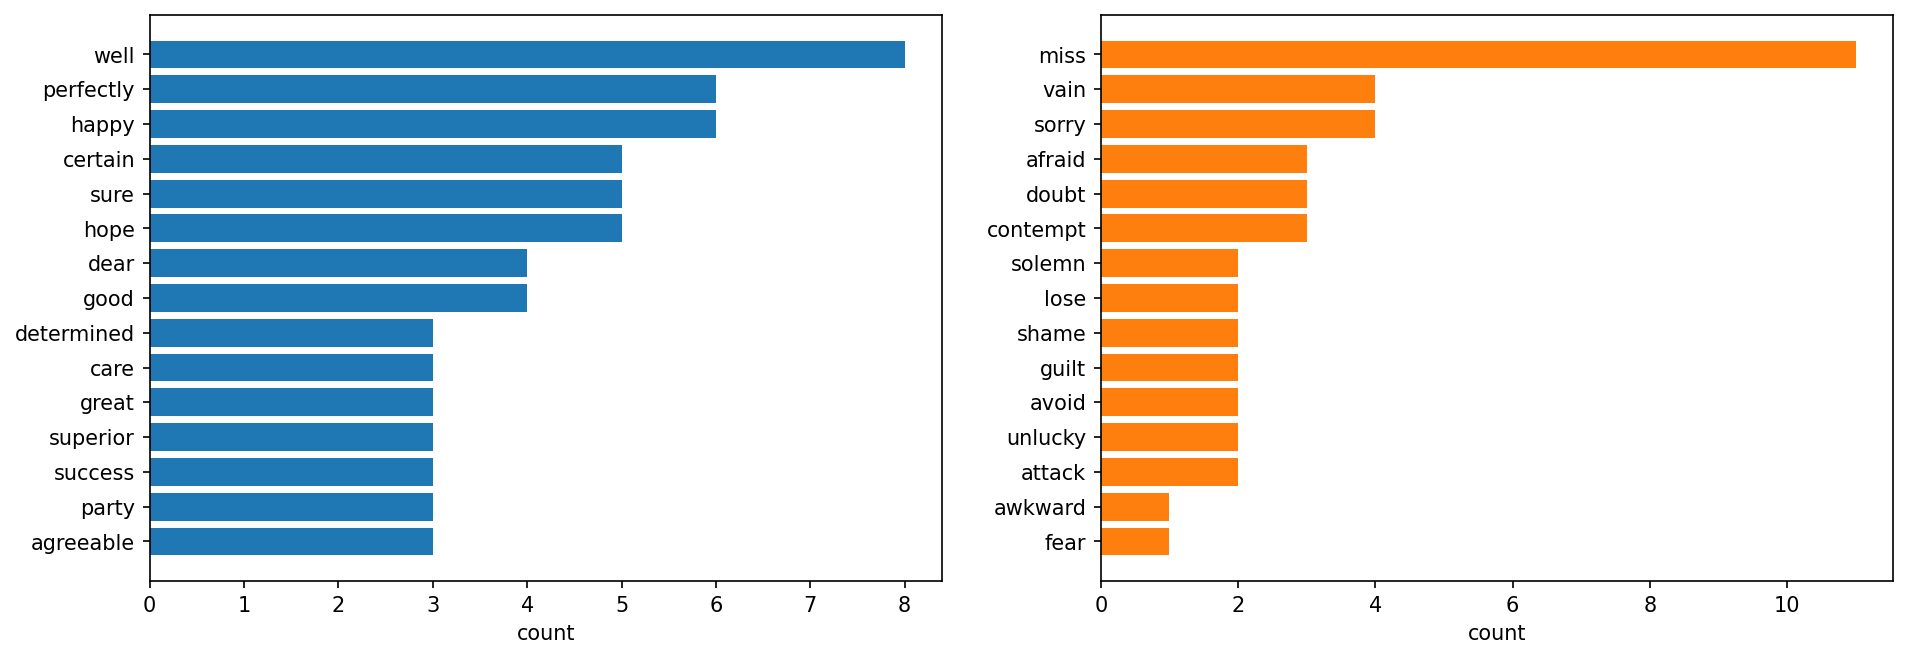

In [90]:
pos = word_count_ch18[word_count_ch18['sentiments']=='positive'].sort_values(['size'],ascending=True)
pos = pos[-15:]
neg = word_count_ch18[word_count_ch18['sentiments']=='negative'].sort_values(['size'],ascending=True)
neg = neg[-15:]
fig, ax = plt.subplots(1,2, figsize = (15, 5))

ax[0].barh(pos['word'],
           pos['size'],
           color = colors[0])
ax[0].set_xlabel('count')
ax[1].barh(neg['word'], 
           neg['size'],
           color = colors[1])
ax[1].set_xlabel('count')

## 3.7 各章情緒分數

In [91]:
sentiment_count

,chapter,sentiments,size,ratio
0,0,NaN,2,1.000000
1,1,affect,47,0.118687
2,1,anger,2,0.005051
3,1,anx,2,0.005051
4,1,negative,9,0.022727
...,...,...,...,...
416,61,anx,2,0.003185
417,61,negative,14,0.022293
418,61,positive,44,0.070064
419,61,sad,4,0.006369


In [92]:
mask = ~book_liwc_df['sentiments'].isna()
book_sentiment_value = sentiment_count.pivot_table(index='chapter', columns='sentiments', values='size', fill_value=0).reset_index().rename_axis(None, axis=1)
book_sentiment_value.head()

,chapter,affect,anger,anx,negative,positive,sad
0,1,47,2,2,9,38,2
1,2,30,0,2,10,20,5
2,3,86,6,3,21,65,8
3,4,71,6,1,15,56,7
4,5,58,3,1,16,41,8


In [93]:
# sentiment 計算方式: positive - anger - anx - negative - sad
book_sentiment_value["sentiment_value"] = (
    book_sentiment_value["positive"]
    - book_sentiment_value["anger"]
    - book_sentiment_value["anx"]
    - book_sentiment_value["negative"]
    - book_sentiment_value["sad"]
)
book_sentiment_value.head()

,chapter,affect,anger,anx,negative,positive,sad,sentiment_value
0,1,47,2,2,9,38,2,23
1,2,30,0,2,10,20,5,3
2,3,86,6,3,21,65,8,27
3,4,71,6,1,15,56,7,27
4,5,58,3,1,16,41,8,13


Text(0, 0.5, 'sentiment value')

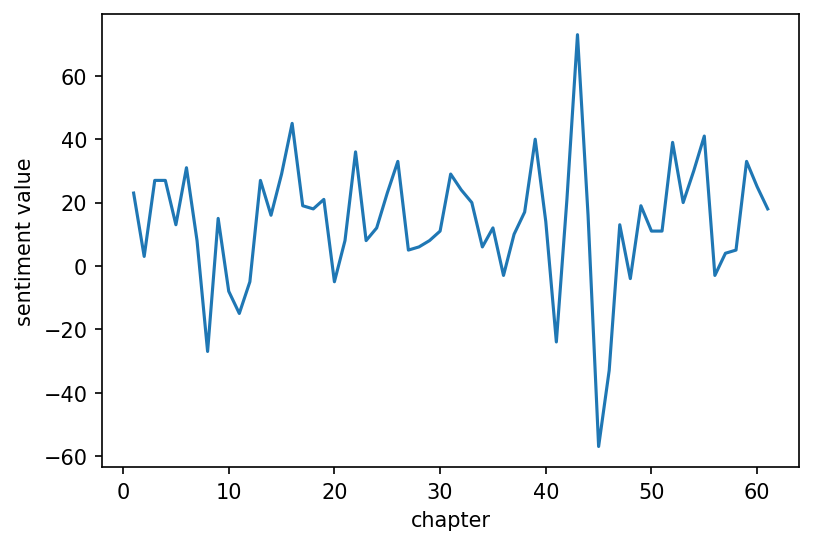

In [94]:
fig, ax = plt.subplots()
ax.plot(book_sentiment_value['chapter'], book_sentiment_value["sentiment_value"])
ax.set_xlabel('chapter')
ax.set_ylabel('sentiment value')

透過情緒分數趨勢圖，可以看出這本書中在不同的章節時，有明顯不同的情緒表現。